## このノートブックの流れ

1.カテゴリ変数でグルーピングした目的変数の平均値の特徴量を全組み合わせ作成

2.カテゴリ変数でグルーピングした目的変数の中央値の特徴量を全組み合わせ作成

3.数値変数同士の積の特徴量を作成

4.数値変数同士の商の特徴量を作成

5.importanceを基に削る

In [1]:
%matplotlib inline                      

import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
plt.rcParams['figure.figsize'] = (10, 8)
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)
import xgboost as xgb
import lightgbm as lgb
import pickle

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [30]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
Id = test.Id
target = train.SalePrice
data = pd.read_csv('../house price/004_data.csv')

In [31]:
nums = [f for f in train.columns if train.dtypes[f] != 'object']
nums.remove('SalePrice')
nums.remove('Id')
cats = [f for f in train.columns if train.dtypes[f] == 'object']

In [32]:
train['SalePrice'] = np.log(train['SalePrice'])

In [33]:
alldata = pd.concat([train, test], sort=False)
alldata

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


## 欠損値補完

In [34]:
alldata['LotFrontage'] = alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for i in mode_fill_li:
    alldata[i].fillna(alldata[i].mode()[0], inplace=True)

for j in None_fill_li:
    alldata[j].fillna('None',inplace=True)

for k in fill_0_li:
    alldata[k].fillna(0, inplace=True)

## カテゴリ変数と数値変数

In [35]:
#group = train.groupby('MSZoning').agg({'SalePrice':['mean']})
#group.columns = ['mean_MSZoning_Price']
#group.reset_index(inplace=True)
#alldata = pd.merge(alldata, group, on=['MSZoning'], how='left')
#alldata

In [36]:
def cat_group_feature(df, train_df, cat_f, agg):
    for c in cat_f:
        group = train_df.groupby(c).agg({'SalePrice':[agg]})
        group.columns = [agg + '_' + c + '_Price']
        group.reset_index(inplace=True)
        df = df.merge(group, on=[c], how='left')
    return df

In [37]:
alldata = cat_group_feature(alldata, train, cats, 'mean')

In [38]:
alldata

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,mean_GarageType_Price,mean_GarageFinish_Price,mean_GarageQual_Price,mean_GarageCond_Price,mean_PavedDrive_Price,mean_PoolQC_Price,mean_Fence_Price,mean_MiscFeature_Price,mean_SaleType_Price,mean_SaleCondition_Price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,12.160778,12.172672,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,12.005034
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,12.160778,12.172672,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,12.005034
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,12.160778,12.172672,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,12.005034
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,11.765643,11.818974,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,11.788774
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,12.160778,12.172672,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,12.005034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,12.059895,NaN,NaN,NaN,11.991061,12.005034
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,11.587994,11.818974,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,11.788774
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,11.765643,11.818974,12.068539,12.070483,12.059895,NaN,NaN,NaN,11.991061,11.788774
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,12.059895,NaN,11.850596,11.868387,11.991061,12.005034


In [39]:
alldata = cat_group_feature(alldata, train, cats, 'median')

In [40]:
alldata

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,median_GarageType_Price,median_GarageFinish_Price,median_GarageQual_Price,median_GarageCond_Price,median_PavedDrive_Price,median_PoolQC_Price,median_Fence_Price,median_MiscFeature_Price,median_SaleType_Price,median_SaleCondition_Price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,12.128111,12.154779,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.982929
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,12.128111,12.154779,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.982929
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,12.128111,12.154779,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.982929
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,11.771436,11.813030,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.775290
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,12.128111,12.154779,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.982929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,12.034691,NaN,NaN,NaN,11.97035,11.982929
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,11.589887,11.813030,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.775290
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,11.771436,11.813030,12.043554,12.043554,12.034691,NaN,NaN,NaN,11.97035,11.775290
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,12.034691,NaN,11.831015,11.877569,11.97035,11.982929


## 数値変数と数値変数

In [41]:
def num_mult(df, num_features):
    if num_features != 'Id':
        for i in num_features:
            for j in num_features:
                if i != j:
                    df[i + '_mult_' + j] = df[i] * df[j]
    return df

In [42]:
num_mult(alldata, nums)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold_mult_GarageCars,YrSold_mult_GarageArea,YrSold_mult_WoodDeckSF,YrSold_mult_OpenPorchSF,YrSold_mult_EnclosedPorch,YrSold_mult_3SsnPorch,YrSold_mult_ScreenPorch,YrSold_mult_PoolArea,YrSold_mult_MiscVal,YrSold_mult_MoSold
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,4016.0,1100384.0,0,122488,0,0,0,0,0,4016
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,4014.0,923220.0,598086,0,0,0,0,0,0,10035
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,4016.0,1220864.0,0,84336,0,0,0,0,0,18072
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,6018.0,1287852.0,0,70210,545632,0,0,0,0,4012
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,6024.0,1678688.0,385536,168672,0,0,0,0,0,24096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0.0,0.0,0,0,0,0,0,0,0,12036
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,2006.0,573716.0,0,48144,0,0,0,0,0,8024
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,4012.0,1155456.0,950844,0,0,0,0,0,0,18054
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0.0,0.0,160480,64192,0,0,0,0,1404200,14042


In [43]:
def num_div(df, num_features):
    if num_features != 'Id':
        for i in num_features:
            for j in num_features:
                if i != j:
                    df[i + '_div_' + j] = df[i] / df[j]
    df = df.replace(np.inf, np.nan)
    return df

In [44]:
num_div(alldata, nums)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold_div_GarageCars,YrSold_div_GarageArea,YrSold_div_WoodDeckSF,YrSold_div_OpenPorchSF,YrSold_div_EnclosedPorch,YrSold_div_3SsnPorch,YrSold_div_ScreenPorch,YrSold_div_PoolArea,YrSold_div_MiscVal,YrSold_div_MoSold
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,1004.000000,3.664234,NaN,32.918033,NaN,NaN,NaN,NaN,NaN,1004.000000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,1003.500000,4.363043,6.734899,NaN,NaN,NaN,NaN,NaN,NaN,401.400000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,1004.000000,3.302632,NaN,47.809524,NaN,NaN,NaN,NaN,NaN,223.111111
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,668.666667,3.124611,NaN,57.314286,7.375,NaN,NaN,NaN,NaN,1003.000000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,669.333333,2.401914,10.458333,23.904762,NaN,NaN,NaN,NaN,NaN,167.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.333333
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,2006.000000,7.013986,NaN,83.583333,NaN,NaN,NaN,NaN,NaN,501.500000
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,1003.000000,3.482639,4.232068,NaN,NaN,NaN,NaN,NaN,NaN,222.888889
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,25.075000,62.687500,NaN,NaN,NaN,NaN,2.865714,286.571429


In [45]:
alldata = alldata.replace(np.inf, np.nan)

In [46]:
alldata

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold_div_GarageCars,YrSold_div_GarageArea,YrSold_div_WoodDeckSF,YrSold_div_OpenPorchSF,YrSold_div_EnclosedPorch,YrSold_div_3SsnPorch,YrSold_div_ScreenPorch,YrSold_div_PoolArea,YrSold_div_MiscVal,YrSold_div_MoSold
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,1004.000000,3.664234,NaN,32.918033,NaN,NaN,NaN,NaN,NaN,1004.000000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,1003.500000,4.363043,6.734899,NaN,NaN,NaN,NaN,NaN,NaN,401.400000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,1004.000000,3.302632,NaN,47.809524,NaN,NaN,NaN,NaN,NaN,223.111111
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,668.666667,3.124611,NaN,57.314286,7.375,NaN,NaN,NaN,NaN,1003.000000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,669.333333,2.401914,10.458333,23.904762,NaN,NaN,NaN,NaN,NaN,167.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.333333
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,2006.000000,7.013986,NaN,83.583333,NaN,NaN,NaN,NaN,NaN,501.500000
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,1003.000000,3.482639,4.232068,NaN,NaN,NaN,NaN,NaN,NaN,222.888889
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,25.075000,62.687500,NaN,NaN,NaN,NaN,2.865714,286.571429


In [47]:
alldata.to_pickle('alldata_many_cols.pkl')

## モデリング

In [21]:
data = import_data('../house price/alldata_many_cols.csv')

C:\Users\user\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Memory usage of dataframe is 59.84 MB
Memory usage after optimization is: 17.93 MB
Decreased by 70.0%


In [22]:
data = data.iloc[:,1:] 
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[:len(train)]
test = data[len(train):]

In [24]:
categorical_cols = cats

In [25]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

(1460, 2686) (1459, 2686)


In [26]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [26]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 7,
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280896	valid_1's rmse: 0.269939
[20]	training's rmse: 0.207339	valid_1's rmse: 0.203449
[30]	training's rmse: 0.162908	valid_1's rmse: 0.169472
[40]	training's rmse: 0.136044	valid_1's rmse: 0.152565
[50]	training's rmse: 0.11933	valid_1's rmse: 0.144497
[60]	training's rmse: 0.108316	valid_1's rmse: 0.140725
[70]	training's rmse: 0.100804	valid_1's rmse: 0.139337
[80]	training's rmse: 0.0951322	valid_1's rmse: 0.138962
Early stopping, best iteration is:
[76]	training's rmse: 0.0971559	valid_1's rmse: 0.138773
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2822	valid_1's rmse: 0.273185
[20]	training's rmse: 0.210432	valid_1's rmse: 0.205117
[30]	training's rmse: 0.167571	valid_1's rmse: 0.165694
[40]	training's rmse: 0.141781	valid_1's rmse: 0.141968
[50]	training's rmse: 0.125787	valid_1's rmse: 0.128512
[60]	training's rmse: 0.115429	valid_1's rmse: 0.121056
[70]

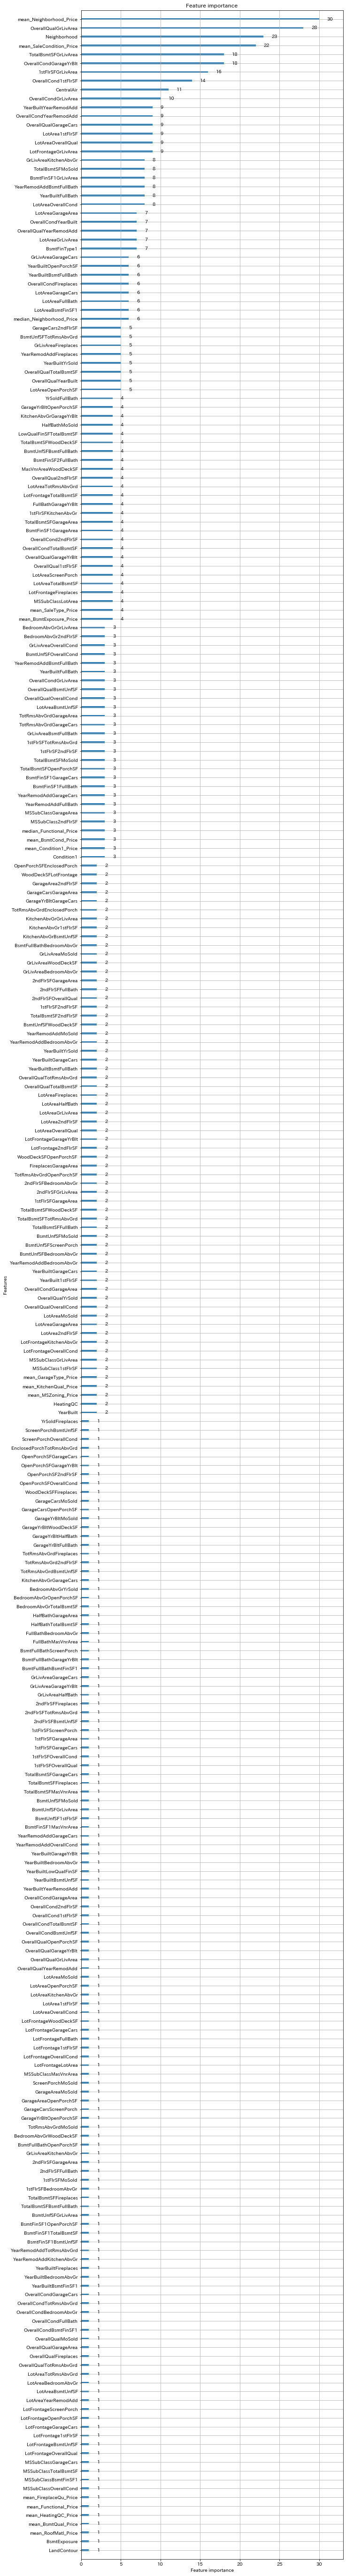

In [27]:
lgb.plot_importance(model, figsize=(10,100))

In [28]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
...,...
YrSold3SsnPorch,0
YrSoldScreenPorch,0
YrSoldPoolArea,0
YrSoldMiscVal,0


In [29]:
importance = importance.sort_values('importance', ascending=False)
importance

,importance
mean_Neighborhood_Price,30
OverallQualGrLivArea,28
Neighborhood,23
mean_SaleCondition_Price,22
TotalBsmtSFGrLivArea,18
...,...
FireplacesBedroomAbvGr,0
FireplacesKitchenAbvGr,0
FireplacesTotRmsAbvGrd,0
FireplacesGarageYrBlt,0


新たに作った特徴量で聞いているものがある様子。ただ、意味あるのかと聞かれたら微妙なものも多い。

## もともとの特徴量を削除してみる

In [48]:
data = pd.read_pickle('../house price/alldata_many_cols.pkl')
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data.drop(cats, axis=1, inplace=True)
data.drop(nums, axis=1, inplace=True)

In [49]:
data.to_pickle('alldata_many_cols.pkl')

In [51]:
data = data.iloc[:,1:]

,SalePrice,mean_MSZoning_Price,mean_Street_Price,mean_Alley_Price,mean_LotShape_Price,mean_LandContour_Price,mean_Utilities_Price,mean_LotConfig_Price,mean_LandSlope_Price,mean_Neighborhood_Price,...,YrSold_div_GarageCars,YrSold_div_GarageArea,YrSold_div_WoodDeckSF,YrSold_div_OpenPorchSF,YrSold_div_EnclosedPorch,YrSold_div_3SsnPorch,YrSold_div_ScreenPorch,YrSold_div_PoolArea,YrSold_div_MiscVal,YrSold_div_MoSold
0,12.247694,12.085885,12.025522,NaN,11.936094,12.022694,12.024183,12.001900,12.020565,12.163641,...,1004.000000,3.664234,NaN,32.918033,NaN,NaN,NaN,NaN,NaN,1004.000000
1,12.109011,12.085885,12.025522,NaN,11.936094,12.022694,12.024183,12.034741,12.020565,12.344176,...,1003.500000,4.363043,6.734899,NaN,NaN,NaN,NaN,NaN,NaN,401.400000
2,12.317167,12.085885,12.025522,NaN,12.163465,12.022694,12.024183,12.001900,12.020565,12.163641,...,1004.000000,3.302632,NaN,47.809524,NaN,NaN,NaN,NaN,NaN,223.111111
3,11.849398,12.085885,12.025522,NaN,12.163465,12.022694,12.024183,12.027446,12.020565,12.206659,...,668.666667,3.124611,NaN,57.314286,7.375,NaN,NaN,NaN,NaN,1003.000000
4,12.429216,12.085885,12.025522,NaN,12.163465,12.022694,12.024183,12.034741,12.020565,12.676000,...,669.333333,2.401914,10.458333,23.904762,NaN,NaN,NaN,NaN,NaN,167.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,NaN,11.692893,12.025522,NaN,11.936094,12.022694,12.024183,12.001900,12.020565,11.474522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.333333
2915,NaN,11.692893,12.025522,NaN,11.936094,12.022694,12.024183,12.001900,12.020565,11.474522,...,2006.000000,7.013986,NaN,83.583333,NaN,NaN,NaN,NaN,NaN,501.500000
2916,NaN,12.085885,12.025522,NaN,11.936094,12.022694,12.024183,12.001900,12.020565,11.933948,...,1003.000000,3.482639,4.232068,NaN,NaN,NaN,NaN,NaN,NaN,222.888889
2917,NaN,12.085885,12.025522,NaN,11.936094,12.022694,12.024183,12.001900,12.020565,11.933948,...,NaN,NaN,25.075000,62.687500,NaN,NaN,NaN,NaN,2.865714,286.571429


In [29]:
train = data[:len(train)]
test = data[len(train):]

In [30]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [31]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 7,
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            )

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           )

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281041	valid_1's rmse: 0.271583
[20]	training's rmse: 0.207551	valid_1's rmse: 0.205139
[30]	training's rmse: 0.162801	valid_1's rmse: 0.1698
[40]	training's rmse: 0.135723	valid_1's rmse: 0.153152
[50]	training's rmse: 0.11888	valid_1's rmse: 0.144612
[60]	training's rmse: 0.107879	valid_1's rmse: 0.141044
[70]	training's rmse: 0.100417	valid_1's rmse: 0.139603
[80]	training's rmse: 0.0950163	valid_1's rmse: 0.139493
[90]	training's rmse: 0.0909578	valid_1's rmse: 0.139098
[100]	training's rmse: 0.0877353	valid_1's rmse: 0.139262
Early stopping, best iteration is:
[90]	training's rmse: 0.0909578	valid_1's rmse: 0.139098
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282168	valid_1's rmse: 0.273739
[20]	training's rmse: 0.210301	valid_1's rmse: 0.20616
[30]	training's rmse: 0.167159	valid_1's rmse: 0.165996
[40]	training's rmse: 0.141713	valid_1's rmse: 0.142193
[5

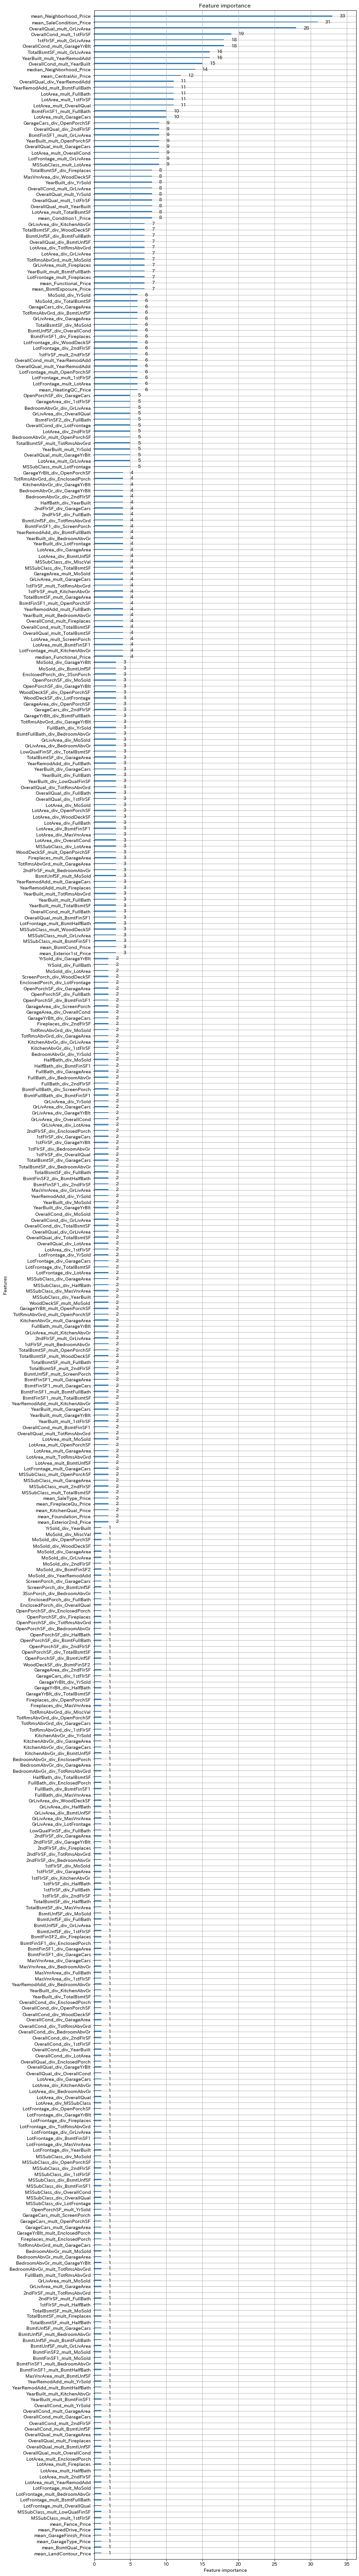

In [32]:
lgb.plot_importance(model, figsize=(10,100))

単体でも効いている特徴量が含まれている特徴量が上位に来ている

In [33]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
mean_Neighborhood_Price,33
mean_SaleCondition_Price,31
OverallQual_mult_GrLivArea,28
OverallCond_mult_1stFlrSF,19
OverallCond_mult_GarageYrBlt,18
...,...
GarageCars_mult_TotalBsmtSF,0
GarageCars_mult_1stFlrSF,0
GarageCars_mult_2ndFlrSF,0
GarageCars_mult_LowQualFinSF,0


In [107]:
importance.index[:100]

Index(['mean_Neighborhood_Price', 'mean_SaleCondition_Price',
       'OverallQual_mult_GrLivArea', 'OverallCond_mult_1stFlrSF',
       'OverallCond_mult_GarageYrBlt', '1stFlrSF_mult_GrLivArea',
       'YearBuilt_mult_YearRemodAdd', 'TotalBsmtSF_mult_GrLivArea',
       'OverallCond_mult_YearBuilt', 'median_Neighborhood_Price',
       'mean_CentralAir_Price', 'YearRemodAdd_mult_BsmtFullBath',
       'OverallQual_div_YearRemodAdd', 'LotArea_mult_FullBath',
       'LotArea_mult_1stFlrSF', 'LotArea_mult_OverallQual',
       'LotArea_mult_GarageCars', 'BsmtFinSF1_mult_FullBath',
       'OverallQual_mult_GarageCars', 'OverallQual_div_2ndFlrSF',
       'LotArea_mult_OverallCond', 'MSSubClass_mult_LotArea',
       'LotFrontage_mult_GrLivArea', 'YearBuilt_mult_OpenPorchSF',
       'BsmtFinSF1_mult_GrLivArea', 'GarageCars_div_OpenPorchSF',
       'OverallQual_mult_1stFlrSF', 'YearBuilt_div_YrSold',
       'OverallCond_mult_GrLivArea', 'MasVnrArea_div_WoodDeckSF',
       'LotArea_mult_TotalBsmtSF'

In [108]:
data[importance.index[:100]]

,mean_Neighborhood_Price,mean_SaleCondition_Price,OverallQual_mult_GrLivArea,OverallCond_mult_1stFlrSF,OverallCond_mult_GarageYrBlt,1stFlrSF_mult_GrLivArea,YearBuilt_mult_YearRemodAdd,TotalBsmtSF_mult_GrLivArea,OverallCond_mult_YearBuilt,median_Neighborhood_Price,...,GarageYrBlt_div_OpenPorchSF,LotArea_mult_BsmtFinSF1,OverallCond_mult_Fireplaces,1stFlrSF_mult_TotRmsAbvGrd,OverallCond_mult_TotalBsmtSF,1stFlrSF_mult_KitchenAbvGr,TotalBsmtSF_mult_GarageArea,LotArea_mult_ScreenPorch,2ndFlrSF_div_FullBath,YearBuilt_div_LotFrontage
0,12.163641,12.005034,11970,4280,10015.0,1463760,4012009,1463760.0,10015,12.191967,...,32.836066,5965700.0,0,6848,4280.0,856,469088.0,0,427.0,30.815385
1,12.344176,12.005034,7572,10096,15808.0,1592644,3904576,1592644.0,15808,12.292250,...,NaN,9388800.0,8,7572,10096.0,1262,580520.0,0,0.0,24.700000
2,12.163641,12.005034,12502,4600,10005.0,1643120,4006002,1643120.0,10005,12.191967,...,47.642857,5467500.0,5,5520,4600.0,920,559360.0,0,433.0,29.426471
3,12.206659,11.788774,12019,4805,9990.0,1650037,3772550,1298052.0,9575,12.209188,...,57.085714,2062800.0,5,6727,3780.0,961,485352.0,0,756.0,31.916667
4,12.676000,12.005034,17584,5725,10000.0,2516710,4000000,2516710.0,10000,12.616525,...,23.809524,9340300.0,5,10305,5725.0,1145,957220.0,0,526.5,23.809524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,11.474522,12.005034,4368,3822,0.0,596232,3880900,596232.0,13790,11.385092,...,NaN,0.0,0,2730,3822.0,546,0.0,0,546.0,93.809524
2915,11.474522,11.788774,4368,2730,9850.0,596232,3880900,596232.0,9850,11.385092,...,82.083333,477288.0,0,3276,2730.0,546,156156.0,0,546.0,93.809524
2916,11.933948,11.788774,6120,8568,13720.0,1498176,3912160,1498176.0,13720,11.941456,...,NaN,24480000.0,7,8568,8568.0,1224,705024.0,0,0.0,12.250000
2917,11.933948,12.005034,4850,4850,0.0,940900,3968064,884640.0,9960,11.941456,...,0.000000,3518617.0,0,5820,4560.0,970,0.0,0,0.0,32.129032


In [35]:
data[importance.index[:200]].to_csv('many_f_top100.csv')